# Import, Analyse and Preprocess data

In [1]:
import pandas as pd
import numpy as np
from dataset import pro_encoder, hhblits_encoder, na_encoder, shhblits_encoder
import pickle

In [2]:
root_dir = 'data/'
hhblits_dir = root_dir + "hhblits/"
X_train = []
for i in ['train']:
    filename = root_dir+'test/'+i+'0.csv'
    df = pd.read_csv(filename)
    # df = df[df['Type_nuc']=='DNA']
    id = df.iloc[:,0].values.tolist(); na_seq = df.loc[:,'Sequence_wild1'].values.tolist()
    mut_seq = df.iloc[:,1].values.tolist(); ori_seq = df.iloc[:,1].values.tolist()
    na_seq = [i.lower() for i in na_seq]
    ori_seq = [i.upper() for i in ori_seq]
    mut_seq = [i.upper() for i in mut_seq]
    pro_ori = pro_encoder(ori_seq)
    pro_mut = pro_encoder(mut_seq)
    na = na_encoder(na_seq)
    hhb_ori, hhb_mut = hhblits_encoder(hhblits_dir,id)
    for i in range(df.shape[0]):
        ori = np.array(pro_ori[i]).flatten(); mut = np.array(pro_ori[i]).flatten()
        nna = np.array(na[i]).flatten()
        sori = np.array(hhb_ori[i]).flatten(); smut = np.array(hhb_mut[i]).flatten()
        X_train.append(np.concatenate((ori,mut,sori,smut,nna)))
    
    y_train = df['ddG(kcal/mol)'].values.tolist()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
X_test = []
root_dir = 'data'
for i in ['test']:
    filename = root_dir+'/test/'+i+'0.csv'
    df = pd.read_csv(filename)
    df = df[df['Type_nuc']=='RNA']
    id = df.iloc[:,0].values.tolist(); na_seq = df.loc[:,'Sequence_wild1'].values.tolist()
    mut_seq = df.iloc[:,1].values.tolist(); ori_seq = df.iloc[:,2].values.tolist()
    na_seq = [i.lower() for i in na_seq]
    ori_seq = [i.upper() for i in ori_seq]
    mut_seq = [i.upper() for i in mut_seq]
    pro_ori = pro_encoder(ori_seq)
    pro_mut = pro_encoder(mut_seq)
    na = na_encoder(na_seq)
    hhb_ori, hhb_mut = hhblits_encoder(hhblits_dir,id)
    for i in range(df.shape[0]):
        ori = np.array(pro_ori[i]).flatten(); mut = np.array(pro_ori[i]).flatten()
        nna = np.array(na[i]).flatten()
        sori = np.array(hhb_ori[i]).flatten(); smut = np.array(hhb_mut[i]).flatten()
        X_test.append(np.concatenate((ori,mut,sori,smut,nna)))
    
    y_test = df['ddG(kcal/mol)'].values.tolist()

In [20]:
y_true = y_test
for i in range(len(y_true)):
    if y_true[i] <1 and y_true[i] > -1:
        y_true[i] = 0
    else:
        y_true[i] = 1

# for i in range(len(y_train)):
#     if y_train[i] <1 and y_train[i] > -1:
#         y_train[i] = 0
#     else:
#         y_train[i] = 1

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# XGBoost Model replace ProNA

In [7]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# import numpy as np
# other_params = {'eta': 0.3, 'n_estimators': 400, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
#                  'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
#                  'seed': 33}

# cv_params = {'n_estimators': np.linspace(1, 10, 11, dtype=int)} 
# # cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 

# xgb_model = xgb.XGBClassifier(**other_params)
# gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
# gs.fit(X_train,y_train)
# gs.best_params_

In [8]:
import xgboost as xgb
reg_xgb = xgb.XGBRegressor(n_estimators=10)
# reg_xgb.fit(X_train, y_train)
# with open('result/xgb_new.pkl', 'wb') as f:
#     pickle.dump(reg_xgb, f)
with open('result/xgb_new.pkl', 'rb') as f:
    reg_xgb = pickle.load(f)

In [9]:
from sklearn.metrics import mean_absolute_error

y_predict = reg_xgb.predict(X_test)
rmse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_xgb.score(X_test, y_test) # (.., 2)
rmse, r2_score

(0.8600950301241409, 0.17425136267307295)

(mean) ACC:  0.6573816155988857 Precision:  0.6575187969924812 Recall:  0.6383490566037736 F1:  0.6365230275342635 AUC:  0.6383490566037736 MCC:  0.2952461817620753


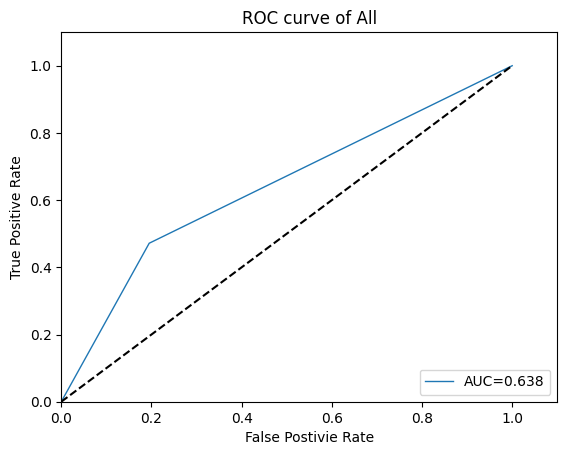

In [13]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

y_score = reg_xgb.predict(X_test)
for i in range(len(y_score)):
    if y_score[i] < 1 and y_score[i] > -1:
        y_score[i] = 0
    else:
        y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

acc_list.append(accuracy_score(y_true, y_score))
precision_list.append(precision_score(y_true, y_score, average='macro'))
recall_list.append(recall_score(y_true, y_score, average='macro'))
f1_list.append(f1_score(y_true, y_score, average='macro'))
fpr, tpr, thresholds = roc_curve(y_true,y_score)   
auc_list.append(auc(fpr, tpr))

plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', matthews_corrcoef(y_true, y_score))
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of All')
plt.savefig('result/roc-prona-trans.png',dpi=300)
plt.show()

with open('result/prona-trans.txt', 'w+') as f:
    f.write(str(np.mean(acc_list))+',')
    f.write(str(np.mean(precision_list))+',')
    f.write(str(np.mean(recall_list))+',')
    f.write(str(np.mean(f1_list))+',')
    f.write(str(np.mean(auc_list))+',')
    f.write(str(matthews_corrcoef(y_true, y_score))+',')

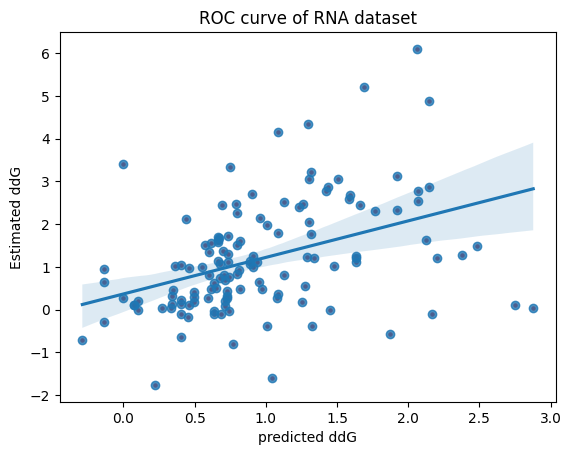

<Figure size 640x480 with 0 Axes>

In [22]:
import seaborn as sb
y_score = reg_xgb.predict(X_test)
plt.scatter(y_score, y_test, c='r', s=5)
plt.xlabel('predicted ddG')
plt.ylabel('Estimated ddG')
plt.title('ROC curve of RNA dataset')
sb.regplot(x=y_score, y=y_test)
plt.show()
plt.savefig('result/RNA.png')

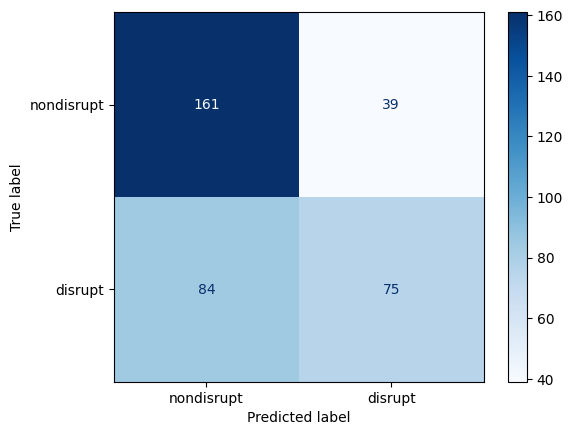

In [14]:
cmex = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmex, display_labels=['nondisrupt','disrupt']).plot(cmap=plt.cm.Blues)
